# Bayesian seats model

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-setup" data-toc-modified-id="Python-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python setup</a></span></li><li><span><a href="#Get-the-data" data-toc-modified-id="Get-the-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get the data</a></span></li><li><span><a href="#Build-a-Stan-model-and-fit-the-data-to-the-model" data-toc-modified-id="Build-a-Stan-model-and-fit-the-data-to-the-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Build a Stan model and fit the data to the model</a></span></li><li><span><a href="#Diagnostics" data-toc-modified-id="Diagnostics-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Diagnostics</a></span></li><li><span><a href="#Visualise-results" data-toc-modified-id="Visualise-results-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Visualise results</a></span><ul class="toc-item"><li><span><a href="#Seats-won" data-toc-modified-id="Seats-won-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Seats won</a></span></li><li><span><a href="#House-outcome" data-toc-modified-id="House-outcome-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>House outcome</a></span></li></ul></li></ul></div>

## Python setup

In [1]:
# Data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import arviz as az
import stan # install with pip - conda is problematic on the M1 MBP
print(f'Stan version: {stan.__version__}')
print(f'ArviZ version: {az.__version__}')

# system imports
import pathlib

Stan version: 3.3.0
ArviZ version: 0.11.4


In [2]:
# enable pystan on jupyter notebook
import nest_asyncio
nest_asyncio.apply()

In [3]:
# plotting stuff
plt.style.use('./markgraph.mplstyle')

CHART_DIR = '../charts'
pathlib.Path(CHART_DIR).mkdir(parents=True, exist_ok=True)
CHART_DIR += '/'

In [4]:
# data locations
SEAT_HISTORY_FILE = '../data/Seat History.csv'

## Get the data

Note: the data was produced by the "Realtionship between votes and seats" notebook.

In [5]:
def fix_column_names(t: pd.DataFrame) -> pd.DataFrame:
    """Replace 'Unnamed' column names with ''."""
    
    replacements = {}
    for c in t.columns:
        if 'Unnamed' in c[1]:
            replacements[c[1]] = ''
    if replacements:
        t = t.rename(columns=replacements, level=1)
    return t

In [6]:
# Load historical elections data
seat_history = pd.read_csv(SEAT_HISTORY_FILE, header=[0, 1], 
                           index_col=0, parse_dates=[0], )
seat_history = fix_column_names(seat_history)
seat_history.index.dtype

dtype('<M8[ns]')

In [7]:
seat_history.columns

MultiIndex([(               'Primary vote',   'ALP'),
            (               'Primary vote',  'L+NP'),
            (               'Primary vote',  'Oth.'),
            (                   '2PP vote',   'ALP'),
            (                   '2PP vote',  'L+NP'),
            (                      'Seats',   'ALP'),
            (                      'Seats',  'L+NP'),
            (                      'Seats',  'Oth.'),
            (                      'Seats', 'Total'),
            ('Governing party at election',      ''),
            (            'Governing since',      ''),
            (             'PM at election',      ''),
            (              'Winning party',      ''),
            (                      'Notes',      ''),
            (             'log gov period',      ''),
            (                     'winner',      ''),
            (      'Govt 2pp votes margin',      ''),
            (          'Govt seats margin',      '')],
           )

In [8]:
# use recent history only
seat_history = seat_history[seat_history.index.year >= 1984]
len(seat_history)

13

## Build a Stan model and fit the data to the model

In [9]:
SEATS_NEXT_PARLIAMENT = 151
WIN_THRESHOLD = 75.5 # which will round up to 76 ...
seats_data = {

    'n_seats': SEATS_NEXT_PARLIAMENT,
    'win_threshold': WIN_THRESHOLD,
    'tpp': 0.47, # Still to code a polling model

    'n_history': len(seat_history),
    'seats': seat_history['Govt seats margin'].values,
    'votes': seat_history['Govt 2pp votes margin'].values,
    
    'others': ((seat_history[('Seats',  'Oth.')] 
               / seat_history[('Seats', 'Total')]).to_list()),
}

In [10]:
seats_model = """
data {
    real<lower=0,upper=1> tpp; // STILL TO CODE: from polls to tpp
    
    real<lower=1> n_seats;     // number of seats in parliament next election
    real<lower=0,upper=n_seats> win_threshold; // account for rounding to ints
    
    int<lower=1> n_history;    // length of election history
    vector<lower=-1,upper=1>[n_history] seats;  // Coalition seats margin (response)
    vector<lower=-1,upper=1>[n_history] votes;  // Coalition votes margin (inputs)

    vector<lower=0,upper=1>[n_history] others;
}

parameters {
    // historical relationship between 2pp votes and seats
    real slope;
    real intercept;
    real<lower=0> sigma; // force half cauchy with lower bound
    
    // historical relationship for other parties in house
    // auto regressive, this year is much like last year
    real drift;
    real replication;
    real<lower=0> s; // force half cauchy with lower bound
    
    // TO DO - model historic polling accuracy for predicting 2pp vote share
}

model {
    // priors on vote difference
    intercept ~ normal(0, 1);
    slope ~ normal(3, 1);      
    sigma ~ cauchy(0, 10);

    // priors on auto-regressive non-major-party seat proportion
    // TO DO - not happy about the constrained priors
    //       - may need to find another way of modelling this.
    drift ~ normal(0.0, 0.01);     // constrained prior
    replication ~ normal(1, 0.01); // constrained prior
    s ~ cauchy(0, 10);

    // linear regression from 2pp vote difference to seats difference
    // TO DO - think about a fatter-tails distribution eg. student_t
    seats ~ normal(intercept + (slope * votes), sigma);
    
    // limited autoregressive(1) model for proportion of non-major-party seats
    for(i in 2:n_history) {
        others[i] ~ normal(drift + (replication * others[i-1]), s);
    }
    
    // TO DO - model historic polling accuracy for predicting 2pp vote share
}

generated quantities {
    real<lower=0,upper=n_seats> other_seats;
    other_seats = (drift + (replication * others[n_history])) * n_seats;

    real<lower=0,upper=n_seats> available_seats;
    available_seats = n_seats - other_seats;

    real<lower=0,upper=n_seats> government_seats;
    government_seats = ((available_seats / 2) 
                        + (((tpp - (1.0 - tpp)) * slope) + intercept) 
                        * (available_seats / 2));

    real<lower=0,upper=n_seats> opposition_seats;
    opposition_seats = (available_seats - government_seats);
    
    int<lower=0,upper=1> government_wins;
    government_wins = government_seats > win_threshold ? 1 : 0;

    int<lower=0,upper=1> opposition_wins;
    opposition_wins = opposition_seats > win_threshold ? 1 : 0;
    
    int<lower=0,upper=1> hung_parliament;
    hung_parliament = (government_wins == 0 && opposition_wins == 0) ? 1 : 0;
}
"""

In [11]:
posterior = stan.build(seats_model, data=seats_data)

Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/yp/w0p94kjs6n38mrs_sjkm51pc0000gn/T/httpstan_4bbde63t/model_p27n3hpc.stan', line 40, column 28: Argument 0.01 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/yp/w0p94kjs6n38mrs_sjkm51pc0000gn/T/httpstan_4bbde63t/model_p27n3hpc.stan', line 39, column 24: Argument 0.01 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).


In [12]:
fit = posterior.sample(num_chains=4, num_samples=25_000)

Sampling:   0%
Sampling:  25% (26000/104000)
Sampling:  50% (52000/104000)
Sampling:  75% (78000/104000)
Sampling: 100% (104000/104000)
Sampling: 100% (104000/104000), done.
Messages received during sampling:
  Gradient evaluation took 2.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.22 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/yp/w0p94kjs6n38mrs_sjkm51pc0000gn/T/httpstan_6jemyltw/model_p27n3hpc.stan', line 49, column 8 to column 67)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Gradient evaluation took 2.1e-05 seconds
  1000 transitions using 10 l

## Diagnostics

In [13]:
az.summary(fit)

/Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope,3.341,0.456,2.484,4.209,0.001,0.001,114078.0,68441.0,1.0
intercept,0.026,0.021,-0.014,0.064,0.000,0.000,108313.0,64992.0,1.0
sigma,0.072,0.018,0.044,0.105,0.000,0.000,97852.0,66088.0,1.0
drift,0.003,0.004,-0.005,0.010,0.000,0.000,136222.0,70784.0,1.0
replication,0.999,0.010,0.981,1.019,0.000,0.000,141646.0,73230.0,1.0
s,0.016,0.004,0.009,0.023,0.000,0.000,109798.0,62356.0,1.0
other_seats,6.413,0.626,5.224,7.594,0.002,0.001,136165.0,71536.0,1.0
available_seats,144.587,0.626,143.406,145.776,0.002,0.001,136165.0,71536.0,1.0
government_seats,59.669,2.432,55.067,64.316,0.007,0.005,112251.0,67043.0,1.0
opposition_seats,84.917,2.447,80.299,89.612,0.007,0.005,112102.0,67865.0,1.0


/Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<AxesSubplot:title={'center':'intercept'}>,
        <AxesSubplot:title={'center':'intercept'}>],
       [<AxesSubplot:title={'center':'slope'}>,
        <AxesSubplot:title={'center':'slope'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'drift'}>,
        <AxesSubplot:title={'center':'drift'}>],
       [<AxesSubplot:title={'center':'replication'}>,
        <AxesSubplot:title={'center':'replication'}>],
       [<AxesSubplot:title={'center':'s'}>,
        <AxesSubplot:title={'center':'s'}>],
       [<AxesSubplot:title={'center':'other_seats'}>,
        <AxesSubplot:title={'center':'other_seats'}>],
       [<AxesSubplot:title={'center':'government_seats'}>,
        <AxesSubplot:title={'center':'government_seats'}>],
       [<AxesSubplot:title={'center':'opposition_seats'}>,
        <AxesSubplot:title={'center':'opposition_seats'}>],
       [<AxesSubplot:title={'center':'government_wins'}>,
 

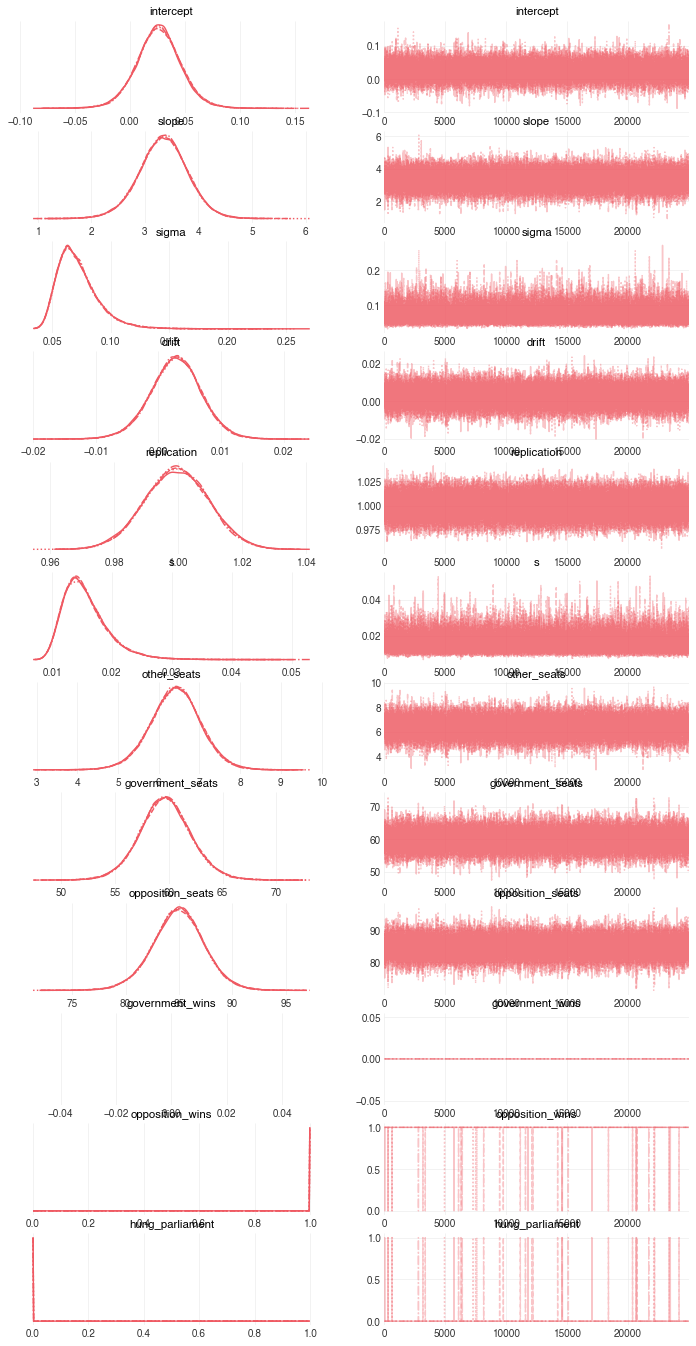

In [14]:
az.plot_trace(fit, var_names=['intercept', 'slope', 'sigma', # 
                              'drift', 'replication', 's',
                              'other_seats', 'government_seats',
                              'opposition_seats', 'government_wins',
                              'opposition_wins', 'hung_parliament'])

## Visualise results

In [15]:
results_df = fit.to_frame()

In [16]:
results_df.columns

Index(['lp__', 'accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__',
       'divergent__', 'energy__', 'slope', 'intercept', 'sigma', 'drift',
       'replication', 's', 'other_seats', 'available_seats',
       'government_seats', 'opposition_seats', 'government_wins',
       'opposition_wins', 'hung_parliament'],
      dtype='object', name='parameters')

In [17]:
def plot_finalise(ax, title=None, xlabel=None, ylabel=None, lfooter=None):
    
    # annotate the plot
    if title is not None:
        ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    if lfooter is not None:
        ax.figure.text(0.005, 0.005, lfooter, 
                       ha='left', va='bottom',
                       c='#999999', style='italic', 
                       fontsize=10)
        
    ax.figure.tight_layout(pad=1.1)    
    
    ax.figure.savefig(CHART_DIR+title+'.png', dpi=300)
    
    # close
    plt.show()
    plt.close()

In [18]:
def plot_seats_won(party, title, colour):
    sw = results_df[party].round(0).value_counts()
    sw = sw.sort_index() / sw.sum()
    outright_win = sw[sw.index > WIN_THRESHOLD].sum() / sw.sum()
    lfooter = f'Outright win probability = {round(outright_win, 5)}'
    sw.index = sw.index.astype(int)
    _, ax = plt.subplots()
    ax.bar(x=sw.index, height=sw, color=colour)
    plot_finalise(ax, title,
                  xlabel='Number of seats won',
                  ylabel='Probability',
                 lfooter=lfooter)

### Seats won

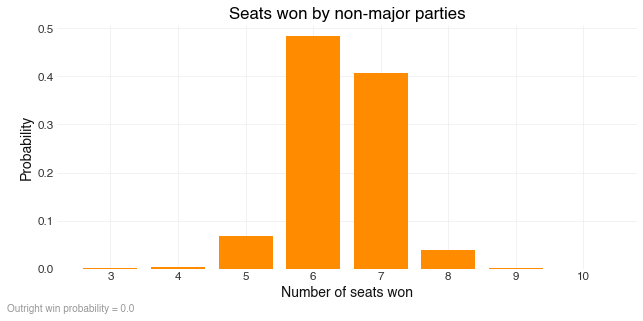

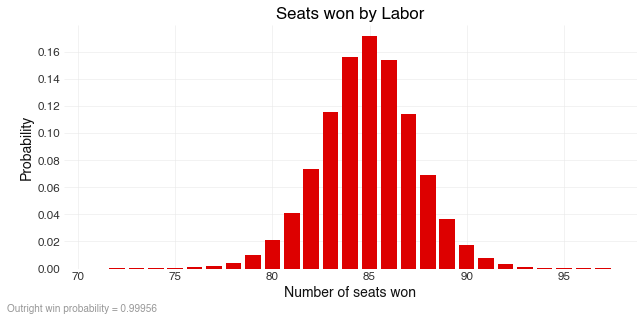

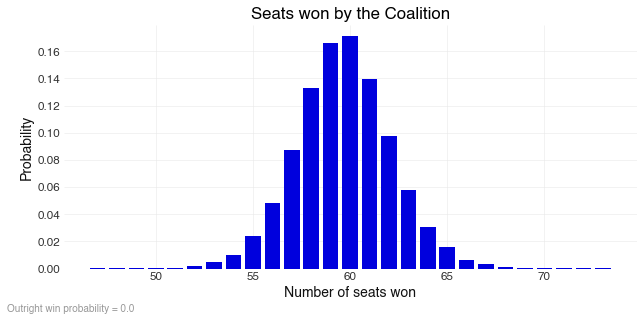

In [19]:
plot_seats_won('other_seats', 'Seats won by non-major parties', 'darkorange')
plot_seats_won('opposition_seats', 'Seats won by Labor', '#dd0000')
plot_seats_won('government_seats', 'Seats won by the Coalition', '#0000dd')

### House outcome

parameters
Labour Wins Outright       0.99956
Hung Parliament            0.00044
Coalition Wins Outright    0.00000
dtype: float64


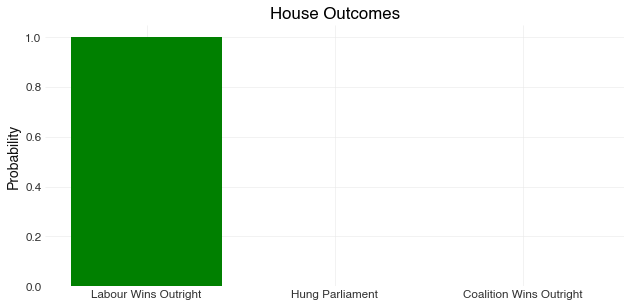

In [20]:
ho = results_df[['government_wins', 'opposition_wins', 'hung_parliament']].sum()
renamer = {
    'opposition_wins': 'Labour Wins Outright',
    'hung_parliament': 'Hung Parliament',
    'government_wins': 'Coalition Wins Outright',
}
ho = ho.rename(index=renamer)
order = list(renamer.values())
ho = (ho / ho.sum())[order]
print(ho)
_, ax = plt.subplots()
ax.bar(x=ho.index, height=ho, color='green')
plot_finalise(ax, 'House Outcomes',
              xlabel=None,
              ylabel='Probability')